In [3]:
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Embedding, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot

Using TensorFlow backend.


In [4]:
def create_window_data_arrays(arrays,window_size):
    arr_len = len(arrays[0])
    windows = [[array[i-window_size: i] for array in arrays] for i in range(window_size +1,arr_len+1)]
    return np.array(windows)


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])


In [32]:
def example_of_usage():
    future_num_predic_steps = 2
    past_steps_to_use = 3
    arr = np.array([1,2,3,4,5,6,7,8,9,10][:-future_num_predic_steps])
    arr2 = np.array([11, 12, 13, 14,15, 16,17,18,19, 20][:-future_num_predic_steps])
    Y = np.array([111,112, 113, 114,115, 116,117,118,119, 120])


    #Y = np.array([211,212, 213, 214,215, 216,217,218,219, 220])

    X = create_window_data_arrays([arr, arr2], past_steps_to_use)
    Y = create_window_data_array_with_shift(Y,future_num_predic_steps,past_steps +future_num_predic_steps)
    print(X)
    print(Y)
    print(X.shape)
    print(Y.shape)
example_of_usage()

[[[ 2  3  4]
  [12 13 14]]

 [[ 3  4  5]
  [13 14 15]]

 [[ 4  5  6]
  [14 15 16]]

 [[ 5  6  7]
  [15 16 17]]

 [[ 6  7  8]
  [16 17 18]]]
[[115 116]
 [116 117]
 [117 118]
 [118 119]
 [119 120]]
(5, 2, 3)
(5, 2)


In [5]:
    filename_asoc = "../data/grouped_data_day_mean_tweets_sentimentdata-scraper_asociaciones_2016-2020.csv"
    filename_ibex ="../data/grouped_data_day_mean_tweets_sentimentdata-scraper_ibex_2018-2020.csv"
    filename_ibex_prices ="../data/ibex_historico.csv"


    df_asoc = pd.read_csv(filename_asoc, sep=";")
    df_ibex = pd.read_csv(filename_ibex, sep=";")
    df_ibex_prices = pd.read_csv(filename_ibex_prices, sep=",")

    df_x = pd.merge(left=df_asoc, right=df_ibex, left_on='normalised_date', right_on='normalised_date')
    df_total = pd.merge(left=df_x, right=df_ibex_prices, left_on='normalised_date', right_on='Date')
    df_total = df_total.rename(columns={"sentiment_x": "sentiment_asociacones", "sentiment_y": "sentiment_ibex"})
    df_total = df_total.dropna()

    
    num_steps = 7
    future_steps = 1
    X_sent_asoc = df_total["sentiment_asociacones"].values[:-future_steps]
    X_sent_ibex = df_total["sentiment_ibex"].values[:-future_steps]
    X_ibex_prices = df_total["Close"].values[:-future_steps]
    X_ibex_prices_next = df_total["Close"].values

    X = np.array(create_window_data_arrays([X_sent_asoc, X_sent_ibex, X_ibex_prices], num_steps))
    Y = create_window_data_array_with_shift(X_ibex_prices_next,future_steps, num_steps +future_steps)
    print(X.shape, Y.shape)

(838, 3, 7) (838, 1)


In [7]:
    train_X, test_X, train_y, test_y = train_test_split(
    X, Y, test_size=0.10, random_state=1000)
   
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(754, 3, 7) (754, 1) (84, 3, 7) (84, 1)


Train on 754 samples, validate on 84 samples
Epoch 1/100
 - 1s - loss: 3807.5745 - accuracy: 0.0000e+00 - val_loss: 497.6306 - val_accuracy: 0.0000e+00
Epoch 2/100
 - 0s - loss: 198.4771 - accuracy: 0.0000e+00 - val_loss: 128.5692 - val_accuracy: 0.0000e+00
Epoch 3/100
 - 0s - loss: 127.3155 - accuracy: 0.0013 - val_loss: 98.0214 - val_accuracy: 0.0000e+00
Epoch 4/100
 - 0s - loss: 121.3887 - accuracy: 0.0000e+00 - val_loss: 100.4863 - val_accuracy: 0.0000e+00
Epoch 5/100
 - 0s - loss: 121.8126 - accuracy: 0.0000e+00 - val_loss: 111.5065 - val_accuracy: 0.0000e+00
Epoch 6/100
 - 0s - loss: 117.2873 - accuracy: 0.0000e+00 - val_loss: 105.6318 - val_accuracy: 0.0000e+00
Epoch 7/100
 - 0s - loss: 117.8066 - accuracy: 0.0000e+00 - val_loss: 98.0504 - val_accuracy: 0.0000e+00
Epoch 8/100
 - 0s - loss: 115.2110 - accuracy: 0.0013 - val_loss: 98.0048 - val_accuracy: 0.0000e+00
Epoch 9/100
 - 0s - loss: 117.6345 - accuracy: 0.0000e+00 - val_loss: 127.9277 - val_accuracy: 0.0000e+00
Epoch 10/10

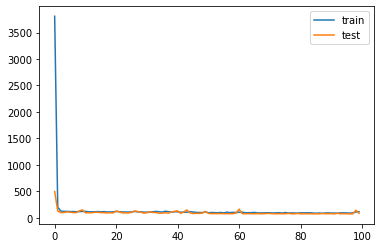

In [8]:
    output_size = future_steps
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(output_size))

    model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
    csv_logger = CSVLogger('log_loss.csv', append=True, separator=';')
    # fit network
    history = model.fit(train_X, train_y, epochs=100, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

In [9]:
#https://datascience.stackexchange.com/a/45172
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(test_X, batch_size=100, verbose=1)
print(mean_absolute_error(test_y, y_pred))

#y_pred_bool = np.argmax(y_pred, axis=1)
#print(classification_report(test_y, y_pred_bool))

84/84 [==============================] - 0s 573us/step
84.81099446651781
